<a href="https://colab.research.google.com/github/fingerman/DeepLearning/blob/master/CNN/CNN_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN with TensorFlow using small data
by G. Adamov  
course: DeepLearning 2018, softuni.bg  
Username: bamse

---
[Link](https://github.com/fingerman/CNN-with-TensorFlow) to the poject on GitHub



## 1. Problem

The aim of this project is to tackle the small-data problem using convents. We will use the [Oxford Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/). It contains 17 categories with 80 images for each class. Before the start the data is splitted into training, validation and test sets each with 60, 10 and 10 images. Each split contains the same number of samles from each class. Hence this is a balanced multiple-class classification problem, which means that classification accuracy will be an appropriate measure of sucess.  

The preprocessed data is available at [Google Drive](https://drive.google.com/drive/folders/1Vo2KPBqhrJlCSYe_r3zTXZxhGI00MWWO?usp=sharing). There are also the pretrained models available. I recommend to move it to your the data to your own GD account if you want to use it. 

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [0]:
# import data if you use your own google drive. 

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# check if gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!ls "/content/drive/My Drive/17flowers"    # check the data available

model_1.h5  model_2.h5	test  train  validation


In [0]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from keras.preprocessing import image
from PIL import Image

Using TensorFlow backend.


## 2. Build the Neural Network

First a simple model we be built. That is a small convent will be trained, without applying any regularization and optimization techniques. This will set a baseline for the accuracy.  
Some rules of thumb setting the convolutional layers will be borrowed from the [Stanford's CNN course](http://cs231n.github.io/convolutional-networks/#layersizepat)  
and such for optimization from the [Keras Blog]( https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) .  

The depth of the feature maps increases from 32 to 64, whereas he siye of feature maps decreases from 297 x 297 to 35 x 35

### 2.1. State the model

In [0]:
dim = 299
num_training_img = 1020 # N of training images
num_val_img = 170       # N of validation images
num_test_img = 170      # N of test images

In [0]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dim, dim, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())  # to from 3D to 1D vector
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(17, activation='softmax')) # fully connected output layer with softmax function 

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 78400)             0         
__________

Next we compile the model architecture. Categorical crossentropz is the loss function used for multiple-class classification problems. The RMSprop optimizer has adaptable learning rate. Further we want to see the model accuracy

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',  
              metrics=['accuracy']) 

### 2.2. Add and process the data

The pictures should be decoded to RGB grids of pixels and converted into floating-point tensors. Their pixel values are rescaled from between 0 and 255 to between 0 and 1. Neural networks prefer to deal with small input values. The images will be turned into batches of preprocesed tensors. A batch size of 16 looks to be optimal - high accuracy while still being quick.

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 16

train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/17flowers/train',
        target_size=(dim, dim),  
        batch_size=batch_size,
        class_mode='categorical')  

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/17flowers/validation',   # target dir
        target_size=(dim, dim),  # resize images
        batch_size=batch_size,
        class_mode='categorical')  # categorical labels


print(validation_generator.class_indices) # check if the model points to each class

Found 1020 images belonging to 17 classes.
Found 170 images belonging to 17 classes.
{'bluebell': 0, 'buttercup': 1, 'colts_foot': 2, 'cowslip': 3, 'crocus': 4, 'daffodil': 5, 'daisy': 6, 'dandelion': 7, 'fritillary': 8, 'iris': 9, 'lily_valley': 10, 'pansy': 11, 'snowdrop': 12, 'sunflower': 13, 'tigerlily': 14, 'tulip': 15, 'windflower': 16}


### 2.3. Fit the model  

The data should be fitted now to the main training model. This is done by using ```fit_generator```. More details can be found at https://keras.io/models/model/#fit_generator. In this case:  
* the first argument ```train_generator``` yelds batches of inputs and targets indefinitely  
* ```steps_per_epoch``` - the data is processed infinitely, so the model needs to know how many samples to draw from the generator bevore declaring an epoch over. That is after having drawn ```steps_per_epoch``` batches from the generator, in other words - after having run for ```steps_per_epoch``` gradient decent steps - the fitting process will go to the next epoch   
* like in the ```fit``` method we can pass ```validation data```. It could be a tuple of Numpy arrays but in our case it is a data generator, with options like the train generator.  
    

In [0]:
history = model.fit_generator(
        train_generator,                                 # passes the training data through this to transform it
        steps_per_epoch=num_training_img // batch_size,  # N steps of GD for each epoch. 63 here
        epochs=50,  
        validation_data=validation_generator,            # pass the validation data 
        validation_steps=num_val_img // batch_size,
        callbacks=[ModelCheckpoint('model_1.h5', verbose=1, save_best_only=True)])  # save model when val_loss decreases

Epoch 1/50
62/63 [============================>.] - ETA: 6s - loss: 2.8761 - acc: 0.1243 
Epoch 00001: val_loss improved from inf to 2.27372, saving model to model_1.h5
63/63 [==============================] - 460s 7s/step - loss: 2.8678 - acc: 0.1273 - val_loss: 2.2737 - val_acc: 0.2562
Epoch 2/50
62/63 [============================>.] - ETA: 0s - loss: 2.0256 - acc: 0.3394
Epoch 00002: val_loss improved from 2.27372 to 1.71755, saving model to model_1.h5
63/63 [==============================] - 11s 182ms/step - loss: 2.0291 - acc: 0.3380 - val_loss: 1.7175 - val_acc: 0.4625
Epoch 3/50
62/63 [============================>.] - ETA: 0s - loss: 1.3078 - acc: 0.6095
Epoch 00003: val_loss improved from 1.71755 to 1.43874, saving model to model_1.h5
63/63 [==============================] - 12s 183ms/step - loss: 1.3056 - acc: 0.6108 - val_loss: 1.4387 - val_acc: 0.5125
Epoch 4/50
62/63 [============================>.] - ETA: 0s - loss: 0.8635 - acc: 0.7440
Epoch 00004: val_loss improved fro

The loss and accuracy of the model over the training and validation data during the training is plotted below:

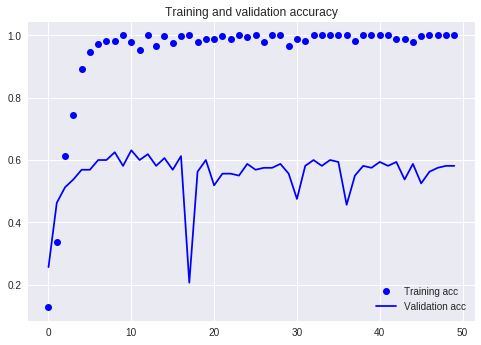

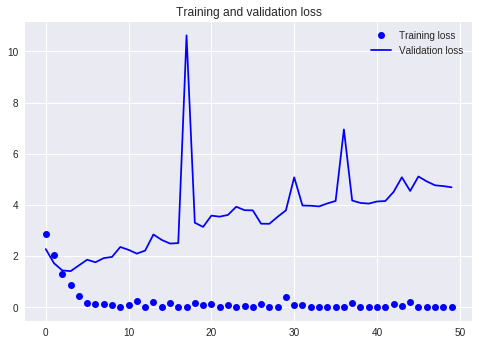

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

 The training accuracy increases until it reaches nearly 100%, while the validation accuracy achieves  60-62%. The validation loss reaches its minimum at the fourth epoch then increases until it doubles and the training loss keeps decreasing linearly until it reaches nearly 0. The plots exemplify overfitting.  
Having in mind we have just very few data - 1190 samples - overfitting is the main problem we have to tackle. However we should also not underestimate the general model problem - a multiple classification task. We are not trying to distinguish between cats and dogs but among different types of flowers which are rather a subsample of each other.  

## 3. Optimize the model

To avoid overfitting we can use dropout or regularization techniques (L1 for instance). Regarding CNN and especially the small-data issue, one can use data augumentation. For the case we will add a Dropout layer before the classifier with 50 % droput rate. But first data augumentation will be used. 

### 3.1. Data Augmentation

Data augmentation  generates more training data from existing training samples using techniques like horizontal flipping, zooming in, rescaling, and setting the fill mode to constant. In this case the convents can study each aspect of the data and hence to generalize better over new data. The outcome of the augmentation over one random image is demonstrated. We add also 2 new layers.

In [0]:
train_datagen1 = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,         # randomly rotate pictures within 180 degrees
        zoom_range=[.65, 1],       # we are zooming in at most 35%
        horizontal_flip=True,      # flipping the image horizontally
        fill_mode='constant')       # strategy to fill newly created pixels

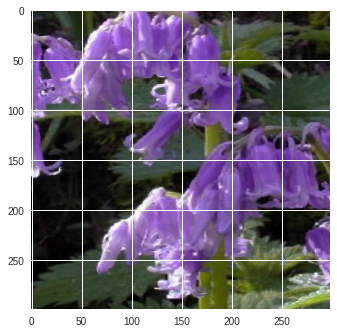

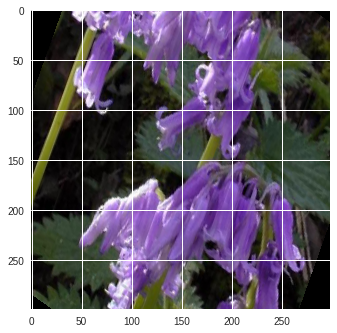

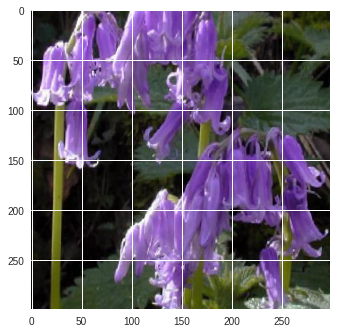

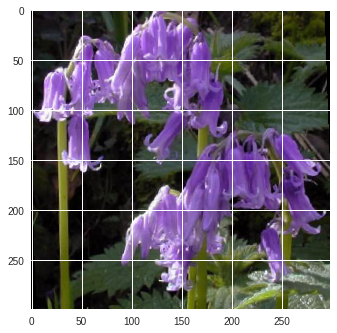

In [0]:
img_path = '/content/drive/My Drive/17flowers/train/bluebell/image_0261.jpg'

# Read and resize 
img = image.load_img(img_path, target_size=(dim, dim))

# Convert it to array
x = image.img_to_array(img)

# Reshape it to (1, dim, dim, 3)
x = x.reshape((1,) + x.shape)


i = 0
for batch in train_datagen1.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

By this time we have more inputs but they are intercorrelated as just existing information was used to produce the new one. That is why a  Dropout layer is added to our model:

In [0]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dim, dim, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(17, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',  
              metrics=['accuracy']) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 33, 32)        18464     
__________

In [0]:
train_datagen = train_datagen1

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 16

train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/17flowers/train',
        target_size=(dim, dim),  
        batch_size=batch_size,
        class_mode='categorical')  

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/17flowers/validation',   
        target_size=(dim, dim), 
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/17flowers/test',   
        target_size=(dim, dim), 
        batch_size=batch_size,
        class_mode='categorical')



Found 1020 images belonging to 17 classes.
Found 170 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


In [0]:
history = model.fit_generator(
        train_generator,  # passes the training data through this to transform it
        steps_per_epoch=num_training_img // batch_size,  # N steps of GD for each epoch. 63 here
        epochs=100,  
        validation_data=validation_generator,  # pass the validation data 
        validation_steps=num_val_img // batch_size,
        callbacks=[ModelCheckpoint('/content/drive/My Drive/17flowers/model_2.h5', verbose=1, save_best_only=True)])  # save model when val_loss decreases

Epoch 1/100
62/63 [============================>.] - ETA: 4s - loss: 2.7187 - acc: 0.0907
Epoch 00001: val_loss improved from inf to 2.33836, saving model to /content/drive/My Drive/17flowers/model_2.h5
63/63 [==============================] - 332s 5s/step - loss: 2.7148 - acc: 0.0923 - val_loss: 2.3384 - val_acc: 0.2188
Epoch 2/100
62/63 [============================>.] - ETA: 0s - loss: 2.3325 - acc: 0.2157
Epoch 00002: val_loss improved from 2.33836 to 2.00448, saving model to /content/drive/My Drive/17flowers/model_2.h5
63/63 [==============================] - 30s 470ms/step - loss: 2.3242 - acc: 0.2183 - val_loss: 2.0045 - val_acc: 0.2188
Epoch 3/100
62/63 [============================>.] - ETA: 0s - loss: 2.1103 - acc: 0.2648
Epoch 00003: val_loss improved from 2.00448 to 1.78795, saving model to /content/drive/My Drive/17flowers/model_2.h5
63/63 [==============================] - 30s 474ms/step - loss: 2.1089 - acc: 0.2636 - val_loss: 1.7879 - val_acc: 0.3375
Epoch 4/100
62/63 [

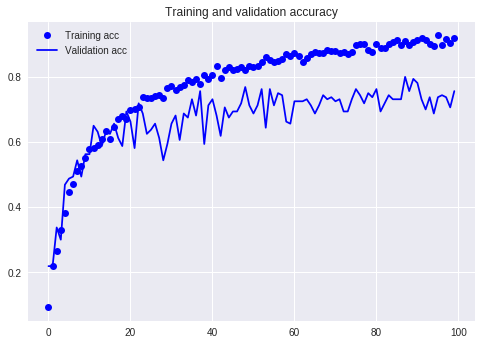

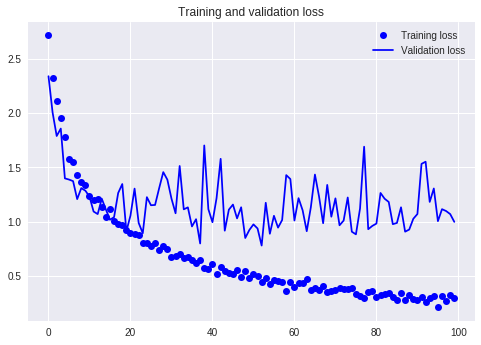

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print('validation accuracy:', val_acc)

validation accuracy: 0.7744845351607529


In [0]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)

test accuracy: 0.8208762891206545


Nevertheless we applied data augmentation and dropout, the problem of overfitting having small data is still present. However the current model of this project achieves an average of 78 % accuracy over the validation (an 18 % relevant improvement) and 82 % over the test set. That is pretty close to the benchmark available in the current research using CNN with the Oxford 17 Flowers Dataset:  that is 70 %  without and 79 % with data augmentation. For reference see: [Hiary et al.., Flower Classification using Deep
Convolutional Neural Networks, 2015, IET Research Journals](https://ora.ox.ac.uk/objects/uuid:b586850f-61b8-4183-81de-937ef1750c79/download_file?file_format=pdf&safe_filename=Yaqub%2Bet%2Bal%252C%2BFlower%2Bclassification%2Busing%2Bdeep%2Bconvolutional%2Bneural%2Bnetworks.pdf&type_of_work=Journal+article)

### 3.2. Further Optimization

The fact that even the first postulation of the CNN model achieved the international scientific benchmark regarding its accuracy speaks about its relevance :). However optimizations can be tryed out in different aspects. One could experiment with the number and structure of the layers. such as the number of filters per convolutional layer for instance. Maybe this will add another 5 to 10 % to the accuracy but having so little data will constrain further improvemen.  

  In this sense one could take other measures like using a pretrained convent model. Pretrained networks are usually trained on a large-scale image datasets. Suitable for this purpose will be the [InceptionV3](https://github.com/tensorflow/models/tree/master/research/inception) model, which has a significantly higher number of layers than the classifier I made, having around 300 layers compared to about 15 in the custom classifier. Others are ImageNet, VGG, ResNet and etc. There are two ways in general to use a pretrained network. Feature extraction and fine-tuning. However those are not topics of the current project. 

## 4. Visualization

Here I will try to visualize how convents learn. CNNs are representations of visual concepts and there exist a large set of techniques to visualize them. 

First it makes sense to take a look at the outputs of each convent within the model - the intermediate outputs. This helps to understand how their successive convnet layers transform their input.

The output of a layer is also called its "activation", the output of the activation function. I show the *output feature maps*, that are the output of certain convolution and pooling layers. This gives a clue how the input is decomposed into the different filters learned by the network. In our case the feature maps have 3 dimensions: width, height, and depth (channels). Each channel encodes relatively independent features.   
      To try to exemplify this a random image from the test data set is taken. First the imporoved model will be loaded. Then to extract the feature maps a model that takes batches of images as input and outputs the activations of all convolution and pooling layers will be created.

In [0]:
# maybe it is still loaded but however:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/17flowers/model_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 78400)             0         
__________

(1, 299, 299, 3)


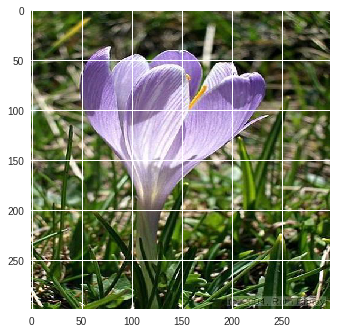

In [0]:
img_path = '/content/drive/My Drive/17flowers/test/crocus/image_0340.jpg'
img = image.load_img(img_path, target_size=(dim, dim))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255. # the preprocessing
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

In [0]:
# take the outputs of the conv layers - the top 6:
layer_outputs = [layer.output for layer in model.layers[:6]] 
# a model that will return these outputs from that model inputs
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)  
activations = activation_model.predict(img_tensor)

The activation of the **1st convolution layer** for the  image input:

In [0]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)
# a 297x297 feature map with 32 channels. 

(1, 297, 297, 32)


Here the display of  the 3rd and the 30th channels:

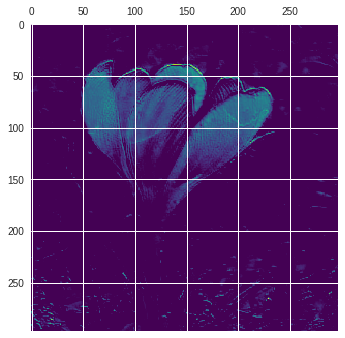

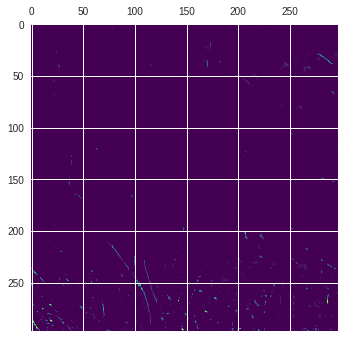

In [0]:
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

It seems like the first convolution is detecting the contours of the objects. Next every channel in each of our 8 activation maps is extracted and plotted. The results are put in one big image tensor, with channels side by side. 

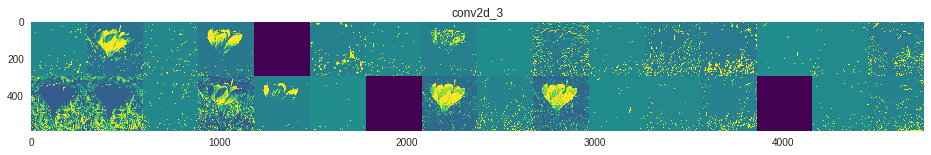

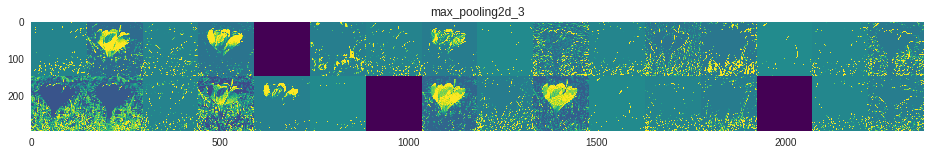

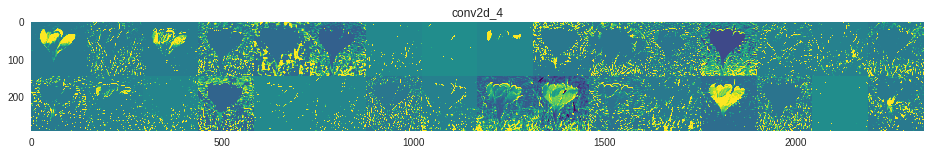

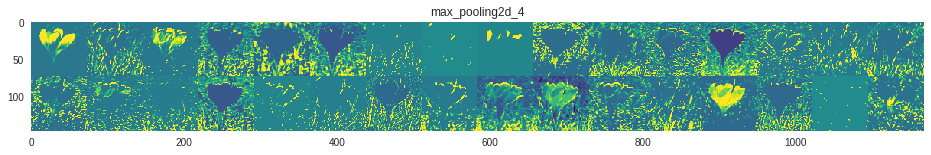

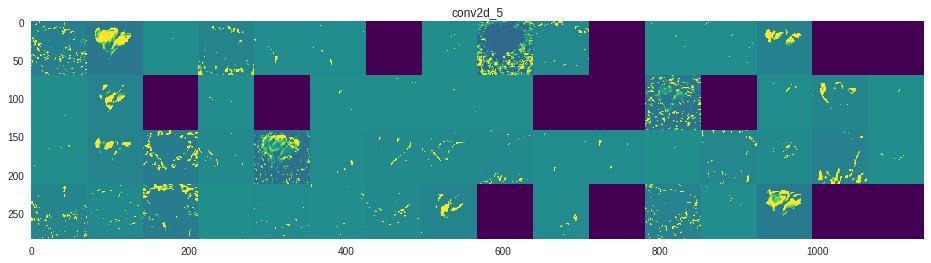

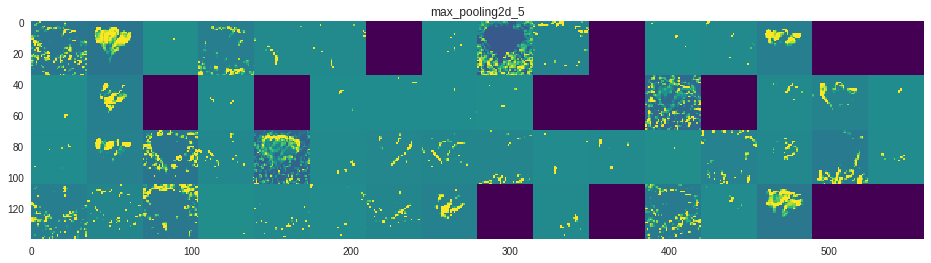

In [0]:
# layers names
layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name)

images_per_row = 16

#  feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # N of features in the feature map
    n_features = layer_activation.shape[-1]

   
    size = layer_activation.shape[1]

    # put thechannels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # put each filter into this grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Maybe not completely visible from our case, but usually the first layer in the network is responsible for the collection of various edge detectors. Here the activations are still keep the biggest part of the information present in the initial picture. As deeper we go, as abstract and unclear to interpret become the activations. 

### 5. Conclusion

In this project the Oxford Flowers Dataset for the classification of 17 groups of flowers was used. Originally a classifier built from scratch was applied. The CNN-Network rendered an accuracy of nearly 60 %. The problem was mainly overfitting, especially having the small-data used for the project.  After applying data augmentation and adding a dropout layer there has been a 13 %  improvment achieved - an average of 73 % accuracy over the validation and 78 % over the test set. Having in mind the research on this topic with our data set,  that are actually remarkable results for a model bult from scratch. At the end the way convolutions "learn" was exemplified. 